# **1. Import Library**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics.pairwise import cosine_similarity
from IPython.display import display

# **2. Load Dataset**

In [2]:
# Load Dataset
df = pd.read_csv("health_insurance.csv")
print(df.head())

   ClaimAmount  PatientAge  PatientIncome ProviderSpecialty  ClaimType  \
0      3807.95          16       90279.43        Cardiology    Routine   
1      9512.07          27      130448.02        Pediatrics    Routine   
2      7346.74          40       82417.54        Cardiology  Emergency   
3      6026.72          65       68516.96         Neurology    Routine   
4      1644.58          24       84122.17  General Practice  Inpatient   

  PatientEmploymentStatus ClaimSubmissionMethod  
0                 Retired                 Paper  
1                 Student                Online  
2                Employed                Online  
3                 Student                 Phone  
4                 Student                 Phone  


# **3. Exploratory Data Analysis (EDA)**



In [3]:
# Check dataset shape and column types
print(f"Jumlah baris dan kolom: {df.shape}")
print(df.dtypes)

Jumlah baris dan kolom: (4500, 7)
ClaimAmount                float64
PatientAge                   int64
PatientIncome              float64
ProviderSpecialty           object
ClaimType                   object
PatientEmploymentStatus     object
ClaimSubmissionMethod       object
dtype: object


In [4]:
# Check missing values and their percentage
print(df.isnull().sum())
missing_percentage = df.isnull().sum() / len(df) * 100
print(missing_percentage)

ClaimAmount                0
PatientAge                 0
PatientIncome              0
ProviderSpecialty          0
ClaimType                  0
PatientEmploymentStatus    0
ClaimSubmissionMethod      0
dtype: int64
ClaimAmount                0.0
PatientAge                 0.0
PatientIncome              0.0
ProviderSpecialty          0.0
ClaimType                  0.0
PatientEmploymentStatus    0.0
ClaimSubmissionMethod      0.0
dtype: float64


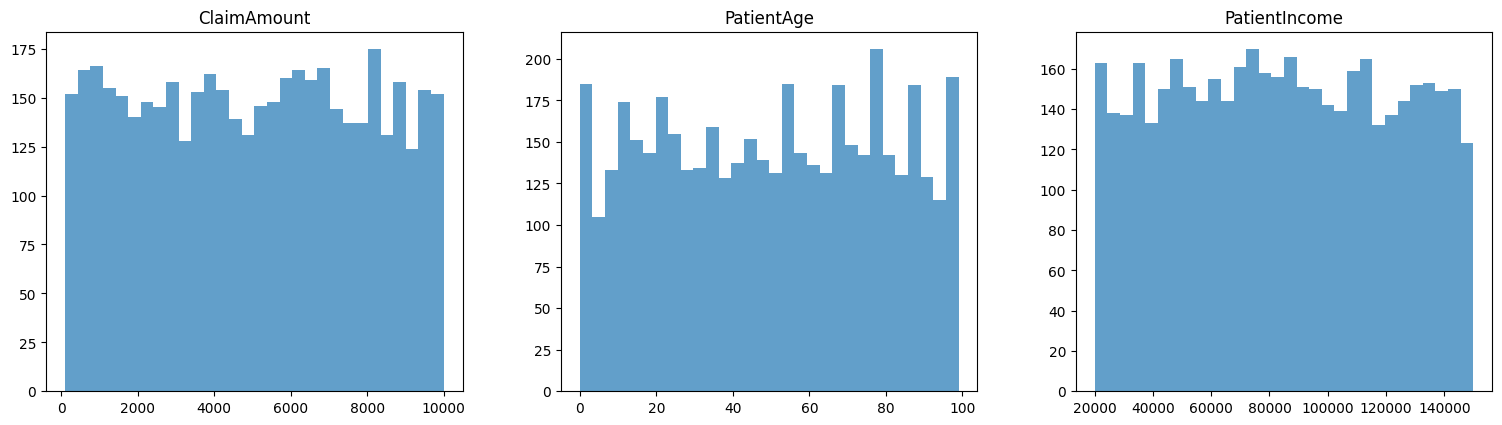

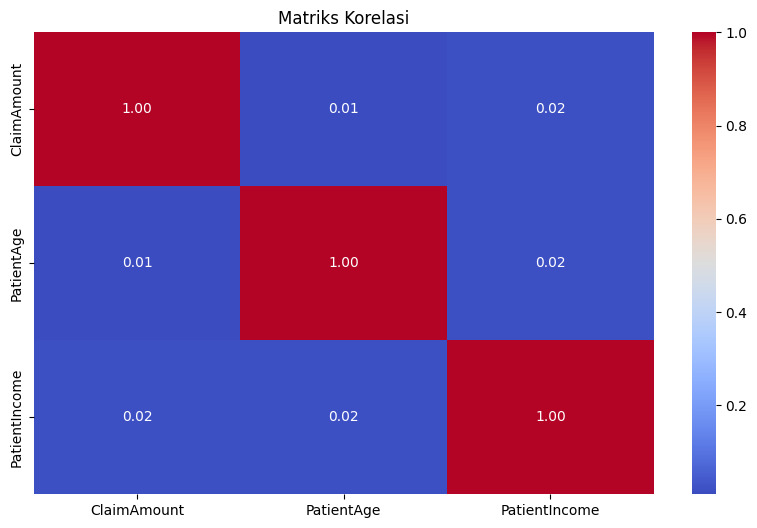

In [5]:
# Plot histograms for numerical features
numeric_df = df.select_dtypes(include=["number"])
fig, axes = plt.subplots(1, len(numeric_df.columns), figsize=(16, 5))
fig.tight_layout(pad=4.0)

for i, col in enumerate(numeric_df.columns):
    axes[i].hist(numeric_df[col], bins=30, alpha=0.7)
    axes[i].set_title(col)

plt.show()

# Heatmap of numerical feature correlations
plt.figure(figsize=(10,6))
numeric_df = df.select_dtypes(include=["number"])
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriks Korelasi")
plt.show()

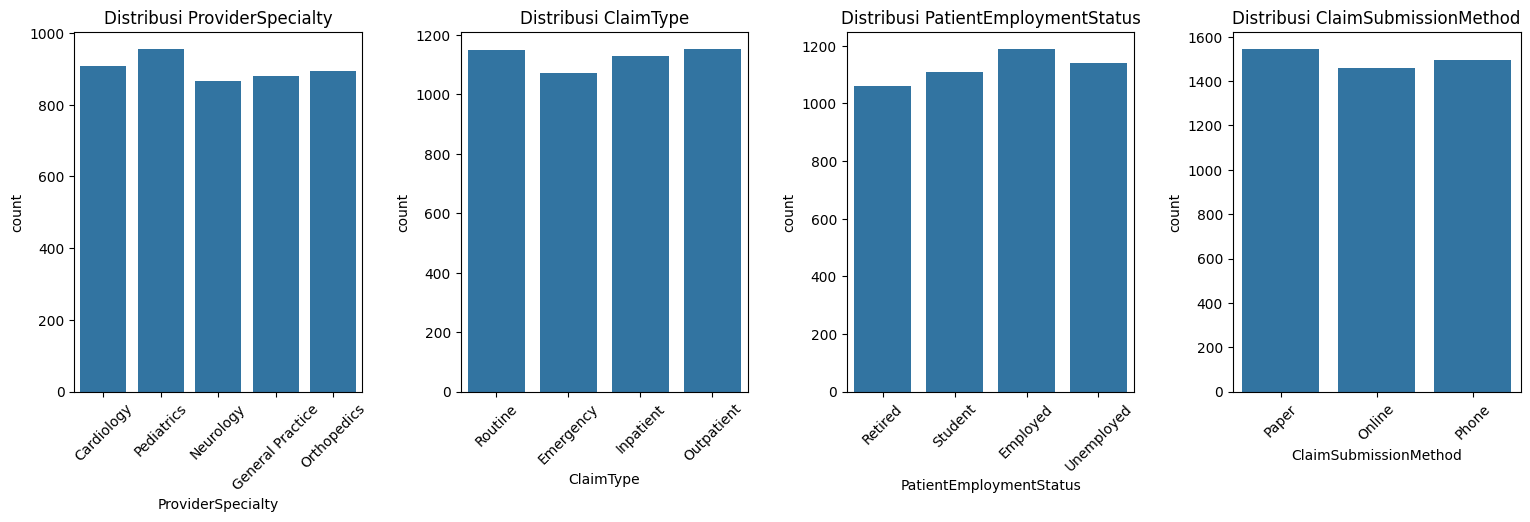

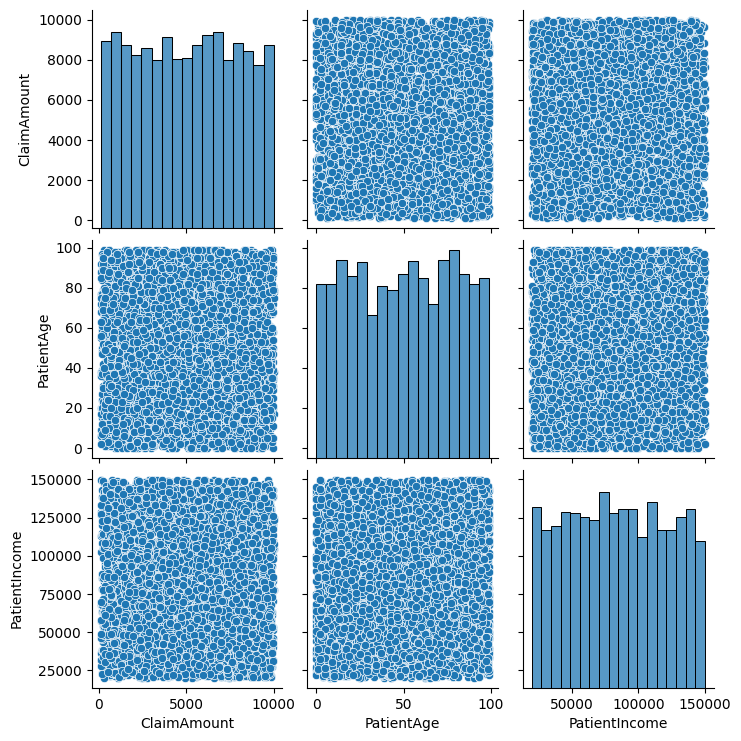

In [6]:
# Bar plots for categorical features
categorical_columns = df.select_dtypes(include=["object"]).columns
fig, axes = plt.subplots(1, len(categorical_columns), figsize=(16, 5))
fig.tight_layout(pad=4.0)

for i, col in enumerate(categorical_columns):
    sns.countplot(x=df[col], ax=axes[i])
    axes[i].set_title(f"Distribusi {col}")
    axes[i].tick_params(axis="x", rotation=45)

plt.show()

#  Pairplot to examine relationships between numerical features
sns.pairplot(df)
plt.show()

# **4. Preprocessing Data**

In [7]:
# Check duplicate rows
duplicate_rows = df.duplicated().sum()
print(f"Jumlah data duplikat: {duplicate_rows}")

Jumlah data duplikat: 0


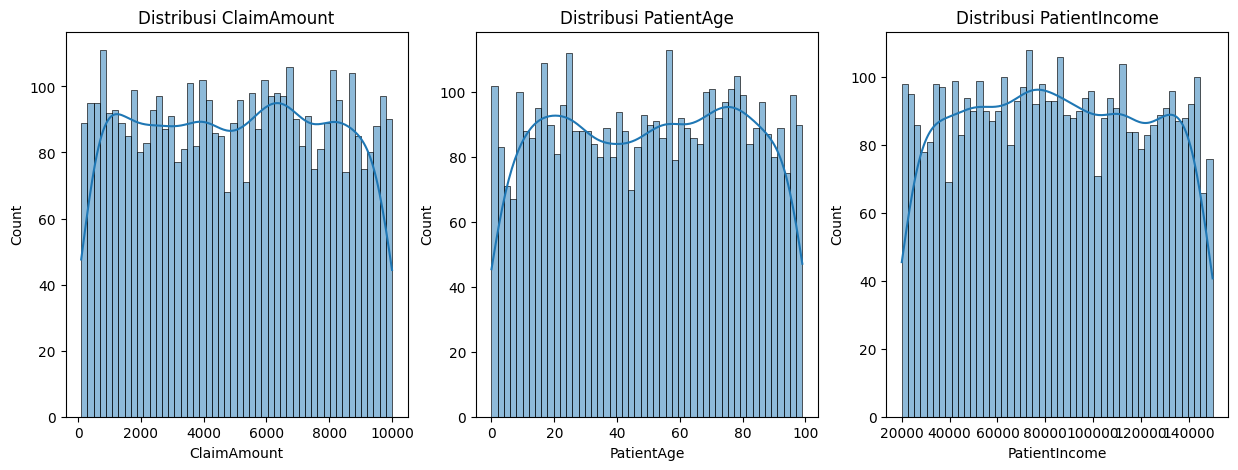

In [8]:
# Plot distributions of numerical features
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(df['ClaimAmount'], bins=50, kde=True, ax=axes[0])
sns.histplot(df['PatientAge'], bins=50, kde=True, ax=axes[1])
sns.histplot(df['PatientIncome'], bins=50, kde=True, ax=axes[2])
axes[0].set_title("Distribusi ClaimAmount")
axes[1].set_title("Distribusi PatientAge")
axes[2].set_title("Distribusi PatientIncome")
plt.show()

In [9]:
# Identify categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns

# Encode categorical features to numeric
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Standardize numerical features
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

# Convert back to DataFrame
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)
print("Data setelah standarisasi:\n", df_scaled.head())

Data setelah standarisasi:
    ClaimAmount  PatientAge  PatientIncome  ProviderSpecialty  ClaimType  \
0    -0.420888   -1.175465       0.158977          -1.414287   1.323516   
1     1.569403   -0.793352       1.242220           1.380440   1.323516   
2     0.813872   -0.341764      -0.053038          -1.414287  -1.375089   
3     0.353289    0.526676      -0.427901          -0.016924   1.323516   
4    -1.175735   -0.897565      -0.007069          -0.715605  -0.475554   

   PatientEmploymentStatus  ClaimSubmissionMethod  
0                -0.432062              -0.009323  
1                 0.450098              -1.243203  
2                -1.314222              -1.243203  
3                 0.450098               1.224557  
4                 0.450098               1.224557  


In [10]:
# Outlier detection using IQR method
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers
df = df[~((df < lower_bound) | (df > upper_bound)).any(axis=1)]
print(f"Jumlah data setelah outlier dihapus: {df.shape[0]}")

Jumlah data setelah outlier dihapus: 4500


In [11]:
# Identify categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns

# Encode categorical columns to numeric
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# **5. Clustering Model Development**

## **a. Building the Clustering Model**

In [12]:
# PCA for Dimensionality Reduction
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df)

# Initialize K-Means with a tentative number of clusters
kmeans = KMeans(n_clusters=3, random_state=42, n_init=50)
labels_kmeans = kmeans.fit_predict(df_pca)

## **b. Evaluating the Clustering Model**

Text(0.5, 1.0, 'Elbow Method')

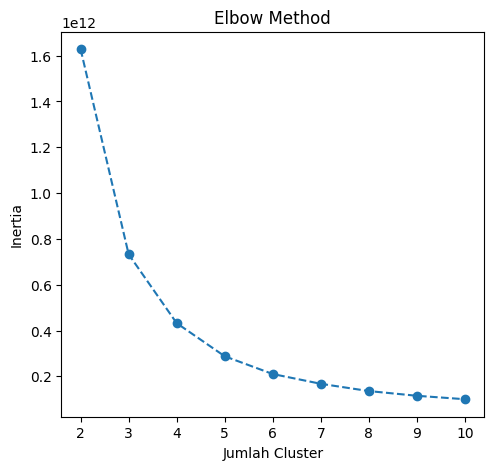

In [13]:
# Test cluster range
range_clusters = range(2, 11)
inertia_values = []
silhouette_scores = []

for k in range_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=50)
    labels = kmeans.fit_predict(df_pca)
    inertia_values.append(kmeans.inertia_)
    silhouette = silhouette_score(df_pca, labels)
    silhouette_scores.append(silhouette)

# Plot Elbow Method
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(range_clusters, inertia_values, marker='o', linestyle='--')
plt.xlabel('Jumlah Cluster')
plt.ylabel('Inertia')
plt.title('Elbow Method')

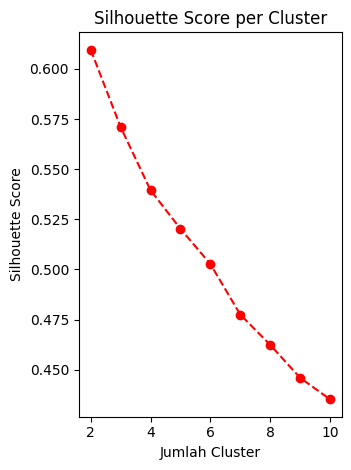

In [14]:
# Plot Silhouette Score
plt.subplot(1,2,2)
plt.plot(range_clusters, silhouette_scores, marker='o', linestyle='--', color='red')
plt.xlabel('Jumlah Cluster')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score per Cluster')
plt.tight_layout()
plt.show()

In [15]:
# Fit K-Means with 2 clusters using Euclidean distance
kmeans = KMeans(n_clusters=2, random_state=42, n_init=50)
labels_kmeans = kmeans.fit_predict(df_pca)

# Compute Silhouette Score using Euclidean distance
silhouette = silhouette_score(df_pca, labels_kmeans)
print(f"Silhouette Score K-Means: {silhouette:.4f}")

Silhouette Score K-Means: 0.6096


In [16]:
# Compute Cosine similarity (to evaluate directional similarity)
cosine_sim = cosine_similarity(df_pca)

# Fit K-Means again using default Euclidean but evaluate with Cosine metric
kmeans = KMeans(n_clusters=2, random_state=42, n_init=100, max_iter=500)
labels_kmeans = kmeans.fit_predict(df_pca)

# Compute Silhouette Score using Cosine similarity
silhouette = silhouette_score(df_pca, labels_kmeans, metric='cosine')
print(f"Silhouette Score K-Means : {silhouette:.4f}")

Silhouette Score K-Means : 0.9498


In [17]:
# Show unique clusters
unique_clusters = np.unique(labels_kmeans)
print(f"Cluster unik yang terbentuk: {unique_clusters}")

Cluster unik yang terbentuk: [0 1]


### Explanation:
Two Silhouette Scores are calculated to assess clustering quality from different perspectives:
- Euclidean distance measures absolute distance between points, reflecting cluster compactness.
- Cosine similarity measures the orientation of data points (angle), highlighting directional separation.

A higher Silhouette Score with Cosine distance indicates clusters are better separated in terms of their relative direction.

## **c. Clustering Result Visualization**

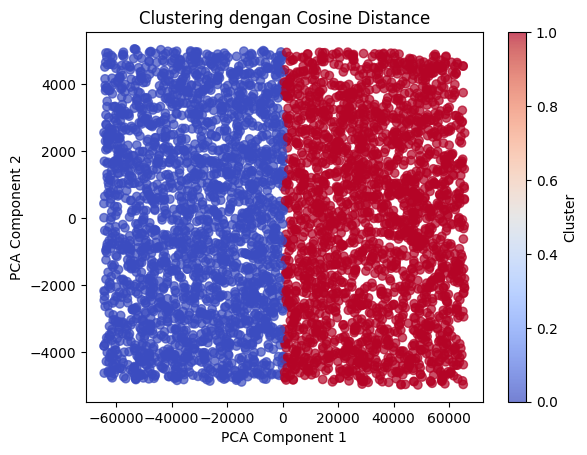

In [18]:
# Scatter plot to visualize clustering results on 2D PCA components
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=labels_kmeans, cmap='coolwarm', alpha=0.7)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Clustering dengan Cosine Distance")
plt.colorbar(label="Cluster")
plt.show()

## **e. Analysis and Interpretation of Clusters**

In [19]:
# Add cluster labels to the dataset
df['Cluster'] = labels_kmeans

In [20]:
# Select features for inverse transformation
selected_features = ['ClaimAmount', 'PatientAge', 'PatientIncome',
                     'ProviderSpecialty', 'ClaimType',
                     'PatientEmploymentStatus', 'ClaimSubmissionMethod']
df_selected = df[selected_features]
df_inverse = scaler.inverse_transform(df_selected)
df_inverse = pd.DataFrame(df_inverse, columns=selected_features)
print(df_inverse.head())

    ClaimAmount   PatientAge  PatientIncome  ProviderSpecialty  ClaimType  \
0  1.091849e+07   510.434791   3.347807e+09           2.024222   4.863723   
1  2.726635e+07   827.094780   4.837330e+09           7.749289   4.863723   
2  2.106057e+07  1201.329312   3.056274e+09           2.024222   1.528667   
3  1.727743e+07  1921.011104   2.540816e+09           4.886756   4.863723   
4  4.718335e+06   740.732965   3.119485e+09           3.455489   2.640352   

   PatientEmploymentStatus  ClaimSubmissionMethod  
0                 2.623359               1.818007  
1                 3.756940               1.007556  
2                 1.489778               1.007556  
3                 3.756940               2.628459  
4                 3.756940               2.628459  


In [21]:
# Copy the inverse-transformed data to final dataframe
df_final = df.copy()
df_final[selected_features] = df_inverse[selected_features]
print(df_final.head())

    ClaimAmount   PatientAge  PatientIncome  ProviderSpecialty  ClaimType  \
0  1.091849e+07   510.434791   3.347807e+09           2.024222   4.863723   
1  2.726635e+07   827.094780   4.837330e+09           7.749289   4.863723   
2  2.106057e+07  1201.329312   3.056274e+09           2.024222   1.528667   
3  1.727743e+07  1921.011104   2.540816e+09           4.886756   4.863723   
4  4.718335e+06   740.732965   3.119485e+09           3.455489   2.640352   

   PatientEmploymentStatus  ClaimSubmissionMethod  Cluster  
0                 2.623359               1.818007        1  
1                 3.756940               1.007556        1  
2                 1.489778               1.007556        0  
3                 3.756940               2.628459        0  
4                 3.756940               2.628459        0  


In [22]:
# Demonstrate the effect of normalization and inverse transformation
print("Sebelum normalisasi:")
print(df[selected_features].describe())

df_scaled = scaler.transform(df[selected_features])
print("\nSetelah normalisasi:")
print(pd.DataFrame(df_scaled, columns=selected_features).describe())

df_inverse = scaler.inverse_transform(df_scaled)
df_inverse = pd.DataFrame(df_inverse, columns=selected_features)
print("\nSetelah inverse_transform:")
print(df_inverse.describe())

Sebelum normalisasi:
       ClaimAmount   PatientAge  PatientIncome  ProviderSpecialty  \
count  4500.000000  4500.000000    4500.000000        4500.000000   
mean   5014.203867    49.838444   84384.284084           2.024222   
std    2866.291066    28.790471   37085.908878           1.431426   
min     100.120000     0.000000   20006.870000           0.000000   
25%    2509.072500    25.000000   52791.905000           1.000000   
50%    5053.765000    50.500000   84061.205000           2.000000   
75%    7462.452500    75.000000  115768.417500           3.000000   
max    9997.200000    99.000000  149957.520000           4.000000   

         ClaimType  PatientEmploymentStatus  ClaimSubmissionMethod  
count  4500.000000              4500.000000            4500.000000  
mean      1.528667                 1.489778               1.007556  
std       1.111809                 1.133707               0.810542  
min       0.000000                 0.000000               0.000000  
25%       1.

In [23]:
# Copy inverse-transformed data to final dataframe
df_final = df_inverse.copy()
print(df_final.head())

   ClaimAmount  PatientAge  PatientIncome  ProviderSpecialty  ClaimType  \
0      3807.95        16.0       90279.43                0.0        3.0   
1      9512.07        27.0      130448.02                4.0        3.0   
2      7346.74        40.0       82417.54                0.0        0.0   
3      6026.72        65.0       68516.96                2.0        3.0   
4      1644.58        24.0       84122.17                1.0        1.0   

   PatientEmploymentStatus  ClaimSubmissionMethod  
0                      1.0                    1.0  
1                      2.0                    0.0  
2                      0.0                    0.0  
3                      2.0                    2.0  
4                      2.0                    2.0  


In [24]:
# Initialize LabelEncoders for categorical features
encoder_provider = LabelEncoder()
encoder_claim = LabelEncoder()
encoder_employment = LabelEncoder()
encoder_submission = LabelEncoder()

# Set the original category names
encoder_provider.classes_ = np.array(['General', 'Cardiology', 'Dermatology', 'Pediatrics', 'Orthopedics'])
encoder_claim.classes_ = np.array(['Routine Check', 'Emergency', 'Surgery', 'Other'])
encoder_employment.classes_ = np.array(['Unemployed', 'Part-time', 'Full-time', 'Self-employed'])
encoder_submission.classes_ = np.array(['Online', 'Phone', 'Mail'])

# Restore categorical columns from integer encoding to original labels
df_final[['ProviderSpecialty', 'ClaimType', 'PatientEmploymentStatus', 'ClaimSubmissionMethod']] = \
    df_final[['ProviderSpecialty', 'ClaimType', 'PatientEmploymentStatus', 'ClaimSubmissionMethod']].astype(int)

df_final['ProviderSpecialty'] = encoder_provider.inverse_transform(df_final['ProviderSpecialty'])
df_final['ClaimType'] = encoder_claim.inverse_transform(df_final['ClaimType'])
df_final['PatientEmploymentStatus'] = encoder_employment.inverse_transform(df_final['PatientEmploymentStatus'])
df_final['ClaimSubmissionMethod'] = encoder_submission.inverse_transform(df_final['ClaimSubmissionMethod'])

print(df_final.head())

   ClaimAmount  PatientAge  PatientIncome ProviderSpecialty      ClaimType  \
0      3807.95        16.0       90279.43           General          Other   
1      9512.07        27.0      130448.02       Orthopedics          Other   
2      7346.74        40.0       82417.54           General  Routine Check   
3      6026.72        65.0       68516.96       Dermatology          Other   
4      1644.58        24.0       84122.17        Cardiology      Emergency   

  PatientEmploymentStatus ClaimSubmissionMethod  
0               Part-time                 Phone  
1               Full-time                Online  
2              Unemployed                Online  
3               Full-time                  Mail  
4               Full-time                  Mail  


In [25]:
# Assign cluster labels to the final dataframe
df_final['Cluster'] = labels_kmeans
if 'Cluster' not in df_final.columns:
    df_final['Cluster'] = df['Cluster']

# Define numerical and categorical columns for cluster analysis
numerical_cols = ['ClaimAmount', 'PatientAge', 'PatientIncome']
categorical_cols = ['ProviderSpecialty', 'ClaimType', 'PatientEmploymentStatus', 'ClaimSubmissionMethod']

mean_df = df_final.groupby('Cluster')[numerical_cols].mean()
mode_df = df_final.groupby('Cluster')[categorical_cols].agg(lambda x: x.mode().iloc[0])
summary_df = pd.concat([mean_df, mode_df], axis=1)

display(summary_df)


,ClaimAmount,PatientAge,PatientIncome,ProviderSpecialty,ClaimType,PatientEmploymentStatus,ClaimSubmissionMethod
Cluster,,,,,,,
0,4976.385549,49.727153,52944.870993,Orthopedics,Other,Unemployed,Mail
1,5053.286783,49.953457,116874.992508,Orthopedics,Surgery,Unemployed,Phone


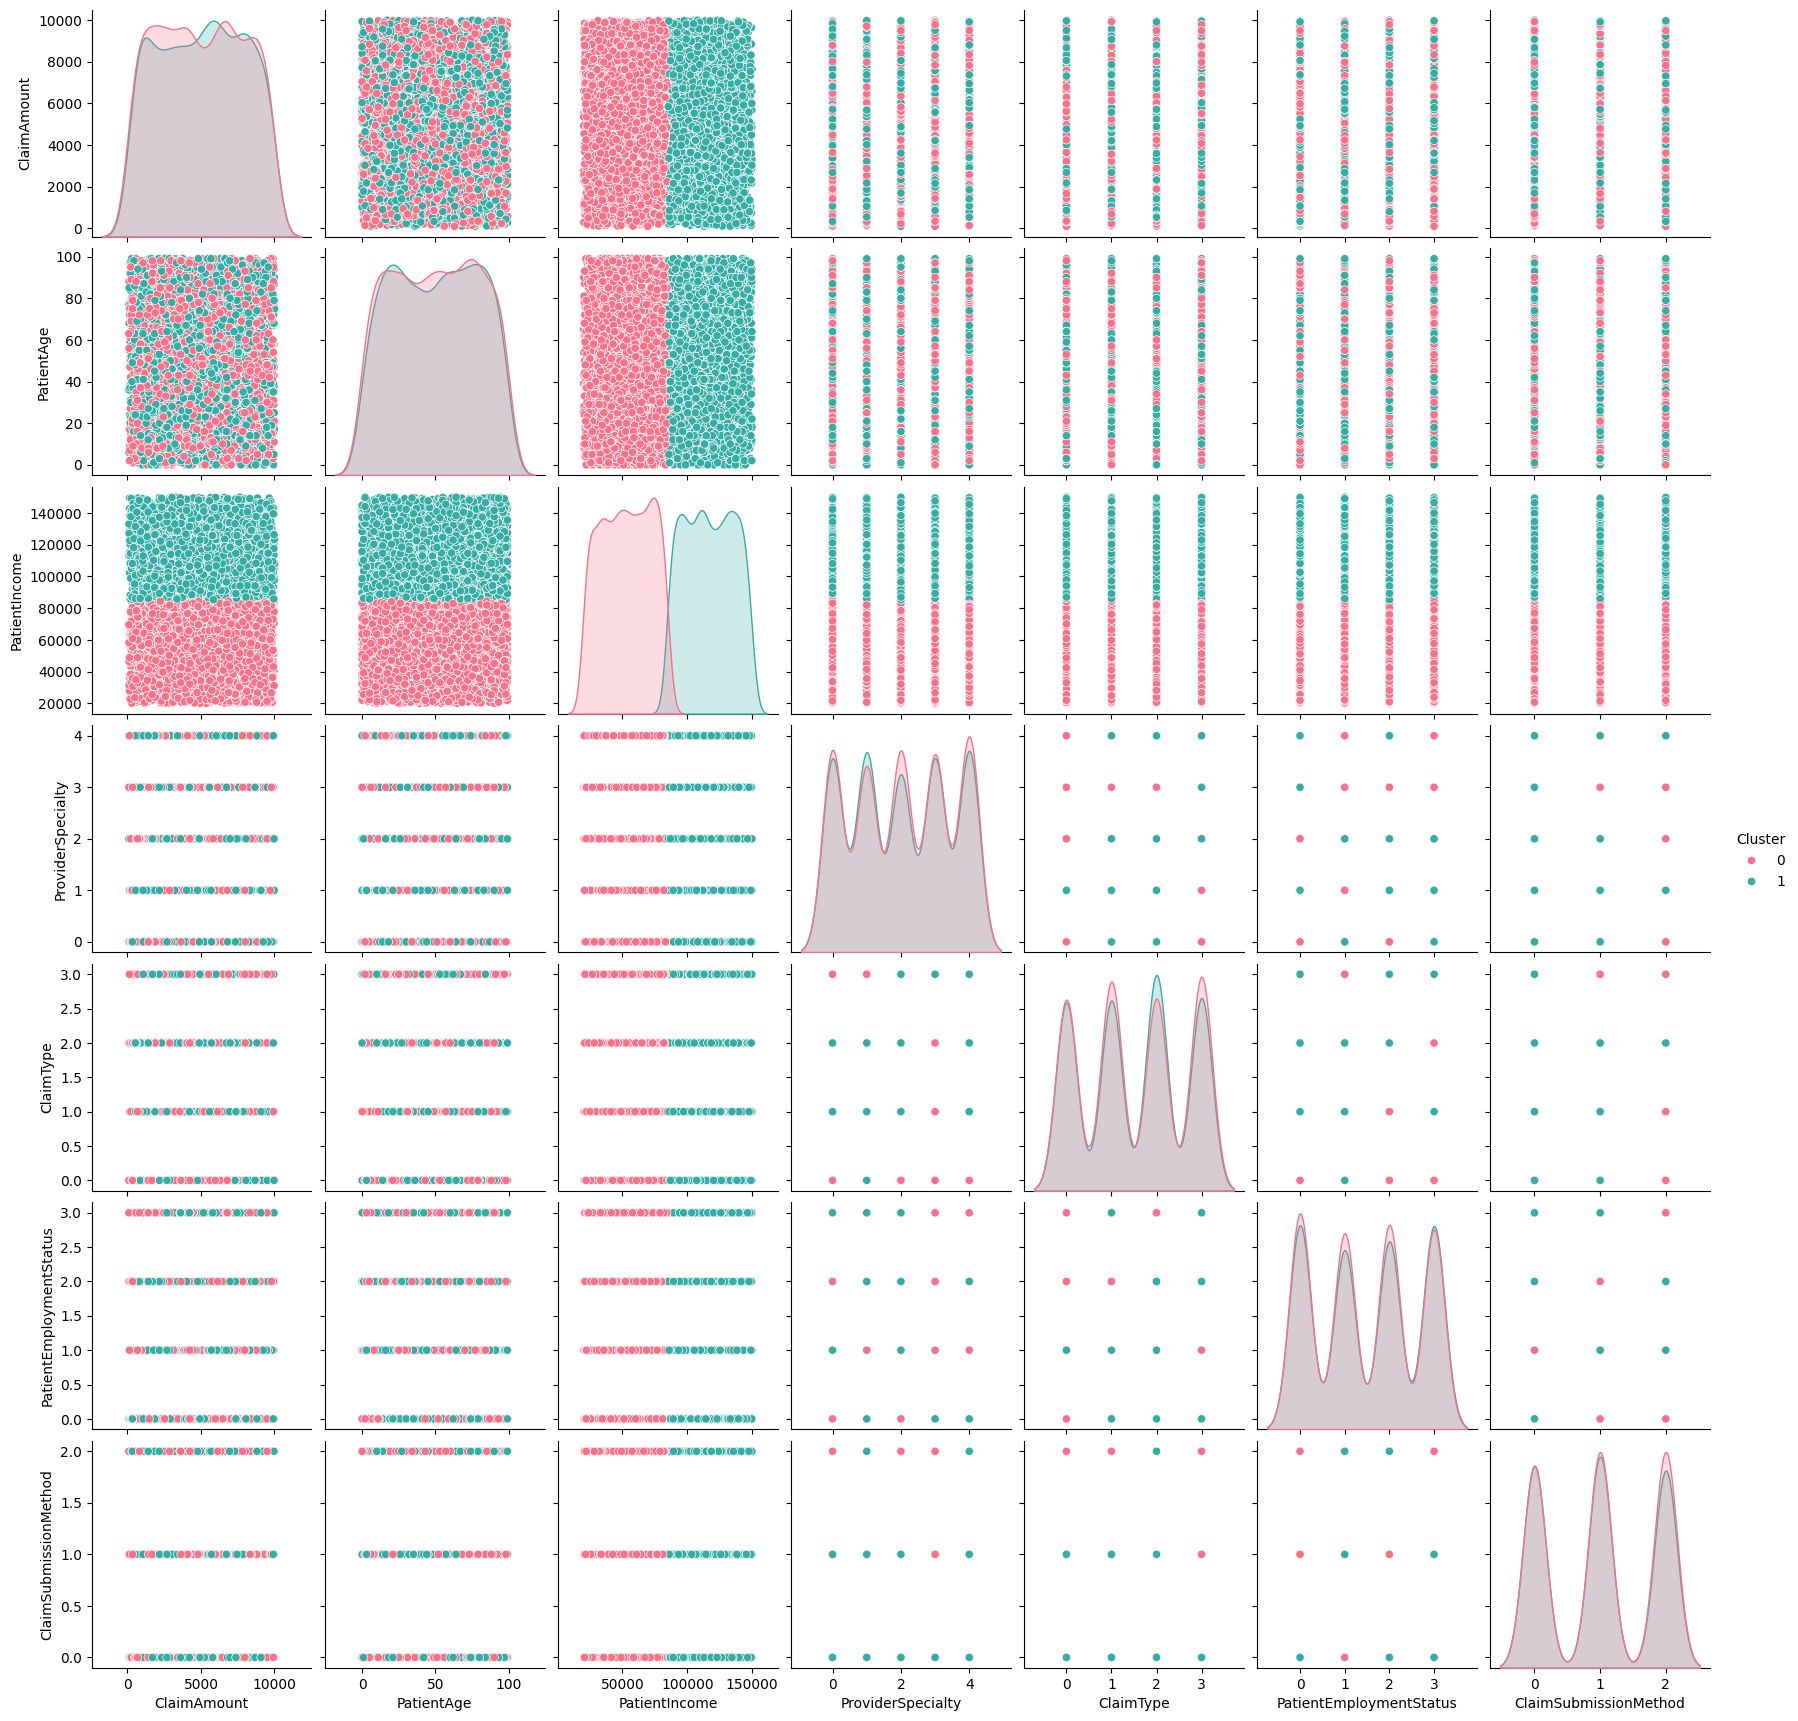

In [26]:
# Visualize cluster separation across features
sns.pairplot(df, hue="Cluster", palette="husl")
plt.show()

# Analisis Karakteristik Cluster dari Model KMeans

Berikut adalah analisis karakteristik untuk setiap cluster yang dihasilkan dari model KMeans.

## Cluster 0 : Pelanggan Risiko Rendah
- Rata-rata ClaimAmount : 4,976
- Rata-rata PatientAge : 49 tahun
- Rata-rata PatientIncome : 52,945
- Rata-rata ClaimType : Other
- Rata-rata ClaimSubmissionMethod : Mail

- Analisis : Cluster ini terdiri dari pelanggan dengan klaim asuransi yang relatif lebih kecil. Dengan penghasilan yang lebih rendah dibandingkan Cluster 1, mereka cenderung mengajukan klaim untuk kebutuhan rutin atau preventif. Selain itu, mayoritas klaim diajukan melalui Mail, yang menunjukkan bahwa pelanggan dalam kelompok ini mungkin tidak terlalu terburu-buru dalam proses klaim atau lebih terbiasa dengan metode administratif konvensional.

## Cluster 1 : Pelanggan Risiko Tinggi
- Rata-rata ClaimAmount : 5,053
- Rata-rata PatientAge : 50 tahun
- Rata-rata PatientIncome : 116,875
- Rata-rata ClaimType : Surgery
- Rata-rata ClaimSubmissionMethod : Phone

- Analisis : Pelanggan dalam Cluster 1 memiliki jumlah klaim yang sedikit lebih tinggi dibandingkan Cluster 0, dengan rata-rata jenis klaim Surgery, yang umumnya membutuhkan biaya lebih besar. Penghasilan mereka juga lebih tinggi, yang dapat berkontribusi pada akses yang lebih luas terhadap layanan kesehatan premium. Selain itu, mereka lebih sering mengajukan klaim melalui Phone, yang bisa menunjukkan bahwa klaim mereka bersifat lebih mendesak atau kompleks.

# Interpretasi Hasil Clustering

## 1. Apakah hasil clustering sesuai dengan ekspektasi dan logika bisnis?
  
Ya, hasil clustering cukup sesuai dengan ekspektasi dan logika bisnis dalam industri asuransi kesehatan.

- Cluster 0 (Pelanggan Risiko Rendah) memiliki rata-rata jumlah klaim yang lebih kecil dengan penghasilan lebih rendah dan cenderung mengajukan klaim untuk kebutuhan rutin atau preventif.

- Cluster 1 (Pelanggan Risiko Tinggi) memiliki klaim yang sedikit lebih besar dengan penghasilan lebih tinggi dan jenis klaim mereka didominasi oleh tindakan medis yang lebih serius seperti operasi.

Dalam dunia asuransi, perbedaan pola ini umum terjadi. Pasien dengan penghasilan lebih tinggi biasanya memiliki akses lebih besar terhadap layanan kesehatan berkualitas dan cenderung melakukan perawatan lebih mahal. Sementara itu, pasien dengan penghasilan lebih rendah mungkin hanya mengakses layanan kesehatan untuk keperluan mendesak atau reguler, sehingga jumlah klaim mereka lebih rendah.


## 2. Apakah ada pola tertentu yang bisa dimanfaatkan?

Ya, ada beberapa pola yang dapat dimanfaatkan untuk strategi bisnis dan pengelolaan risiko dalam industri asuransi :

### **Pola 1 : Perbedaan risiko berdasarkan jenis klaim dan metode pengajuan**
  - Cluster 0 cenderung memiliki klaim untuk kebutuhan rutin atau preventif.
  - Cluster 1 lebih sering mengajukan klaim untuk operasi.

Strategi yang bisa diterapkan :
  - Memberikan edukasi lebih lanjut kepada pelanggan di Cluster 0 mengenai manfaat layanan kesehatan preventif untuk mengurangi risiko penyakit serius di kemudian hari.
  - Mengembangkan layanan klaim yang lebih cepat untuk pelanggan di Cluster 1, seperti hotline prioritas atau otomatisasi pengajuan klaim berbasis telepon.


### **Pola 2 :Potensi Cross-Selling & Upselling**

  - Cluster 0 lebih cocok untuk produk tambahan seperti asuransi kecelakaan atau investasi kesehatan jangka panjang.
  - Cluster 1 lebih membutuhkan cakupan yang lebih luas seperti perlindungan penyakit kritis dan layanan prioritas.

Strategi yang bisa diterapkan:
  - Menawarkan paket asuransi tambahan yang sesuai dengan kebutuhan masing-masing cluster, seperti asuransi kecelakaan dan program kesehatan preventif untuk Cluster 0.

  - Mengembangkan strategi komunikasi yang lebih personal dengan menawarkan produk perlindungan penyakit kritis, asuransi rawat inap dengan cakupan lebih luas atau layanan klaim premium untuk Cluster 1.

# **7. Export Data**

In [27]:
df_final = df.copy()
df_final.to_csv("hasil_clustering.csv", index=False)

In [28]:
!pip freeze > requirements.txt